# Training Cifar10 with Brevitas

## Training a Classifier

The steps to completion are as follows.

1. Load and normalize the Cifar10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on this test data

## Load and Normalize Cifar10



In [1]:
# loaded with torchvision
import torch
import torchvision
import torchvision.transforms as transforms
import time

# brevitas imports
import onnx

Output of torchvision datasets are PILImage images of range [0,1]. These are then transformed to Tensors of normalized range being [-1,1].

In [2]:
# Compose transformation
transform = transforms.Compose(
    [transforms.ToTensor(),     # to a tensor value
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])


# batch size is changed to 3 to see how it differs from what PyTorch themselves obtain in testing accuracy
batch_size = 5

# Downloading the images

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Display some training images for understanding and show.

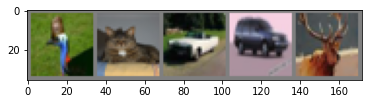

bird  cat   car   car   deer 


In [3]:
# imports for graphic and plotting
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def show_image(img):
    img = img / 2 + 0.5      # un-normalize the image
    norm_img = img           # what does it look like normalized?
    
    npimg = img.numpy()      # numpy image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
# get random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
show_image(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Now that we know that this works. We can begin to define our Convolutional Neural Network.

In [4]:
# Define the Pytorch device. We are going to be using Cuda because I don't have NVIDIA drivers

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Target Device: " + str(device))

Target Device: cpu


/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Define a Convolutional Neural Network

## Brevitas with Weight, activation and bias quantization

- _return_quant_tensor = True_ in all quantized activations. 

    This was done to propagate a QuantTensor to the next layer
    
QuantLinear and QuantConv2d will now know that the input passed into it has been quantized.

Bias quantization is enabled through the Int32Bias quantizer. return_quant_tensor was also set to true for this to work. Each layer with Int32Bias can read the input scale from the QuantTensor passed in and used for quantization.


In [5]:
# import torch neural network libraries
import torch.nn as nn
import torch.nn.functional as F


####################################################################################################################
# Information for the methods that are used in this section
# 
# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, 
#                 bias=True, padding_mode='zeros', device=None, dtype=None)
#
# torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
#
# torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
#   --> Input features correspond to the size of each input sample
#   --> Output features correspond to the size of each output sample
#
# torch.nn.functional.relu(input, inplace=False)
#
####################################################################################################################

####################################################################################################################
# Information Used for Brevitas
# 
# 
####################################################################################################################

import brevitas.nn as qnn
from brevitas.quant import Int32Bias

# setup class for the neural network building
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.quant_inp = qnn.QuantIdentity(bit_width = 4, return_quant_tensor = True)
        
        # Three input channels for the 32x32 images in color
        # Using Brevitas QuantConv2d
        self.conv1 = qnn.QuantConv2d(3, 6, 5, bias = True, weight_bit_width = 4, bias_quant = Int32Bias)   # in_channels = 3, out_channels = 6, kernel_size = 5
        
        self.relu1 = qnn.QuantReLU(bit_width = 4, return_quant_tensor = True)
        
        # input channels is the output of the last Conv2d
        # using Brevitas, 
        self.conv2 = qnn.QuantConv2d(6, 16, 5, bias = True, weight_bit_width = 4, bias_quant = Int32Bias)  # in_channels = 6, out_channels = 16, kernel_size = 5
        
        self.relu2 = qnn.QuantReLU(bit_width = 4, return_quant_tensor = True)
        
        # Fully Connected Layers using Brevitas
        self.fc1 = qnn.QuantLinear(16 * 5 * 5, 120, bias = True, weight_bit_width = 4, bias_quant = Int32Bias)
        
        self.relu3 = qnn.QuantReLU(bit_width = 4, return_quant_tensor = True)
        
        self.fc2 = qnn.QuantLinear(120, 84, bias = True, weight_bit_width = 4, bias_quant = Int32Bias)
        
        self.relu4 = qnn.QuantReLU(bit_width = 4, return_quant_tensor = True)
        
        self.fc3 = qnn.QuantLinear(84, 10, bias = True, weight_bit_width = 4, bias_quant = Int32Bias)
        
    # feed forward
    def forward(self, x):
        
        # forward pass
        x = self.quant_inp(x)
        x = self.relu1(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = self.relu2(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.reshape(x.shape[0], -1)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        
        return x      # output
    
net = Net()

## Define a Loss function and an Optimizer

The loss function that is going to be used is a Classification Cross-Entropy loss and SGD with momentum.

In [153]:
import torch.optim as optim
import torch.nn as nn

lr = 0.001

####################################################################################################################
# torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=- 100, reduce=None, reduction='mean', 
#                           label_smoothing=0.0)
#
# torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False, 
# *, maximize=False, foreach=None, differentiable=False)
####################################################################################################################

# change criterion to BCE with Logits Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

## Train the Network

Now it is time to train the network since we have everything else set up. To do this, we loop over our data iterator, and feed the inputs to the network and optimize.

In [115]:
# start time
start_time = time.time()

def train(net, trainloader, optimizer, criterion):
    losses = []
    
    net.train()
    
    for i, data in enumerate(trainloader, 0):
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        
        # forward pass
        output = net(inputs.float())
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data.cpu().numpy())
        
    print("Model done training!\n")
    return losses
    

# Get final time to test
print("\n--- %s seconds ---" % (time.time() - start_time))


--- 0.0003440380096435547 seconds ---


In [151]:
# network testing function

import torch
from sklearn.metrics import accuracy_score

def test(net, testloader):    
    # ensure model is in eval mode
    net.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for data in testloader:
            inputs, target = data
            inputs, target = inputs.to(device), target.to(device)
            output_orig = net(inputs.float())
            
            # run the output through sigmoid
            output = torch.sigmoid(output_orig)  
            
            # compare against a threshold of 0.5 to generate 0/1
            pred = (output.detach().cpu().numpy() > 0.5) * 1
            target = target.cpu().float()
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.tolist())
        
    return accuracy_score(y_true, y_pred)

Now that the model has been trained, it is important to save it. This is done below.

In [134]:
PATH = '/home/markaye/finn/notebooks/TorchCifar10/TrainedBrevitas_Quantized.pth'

torch.save(net.state_dict(), PATH)

## Test the Network on The Test Data

Now the network has been trained for 2 passes over the training dataset. 
We must check to see if the network has learned anything at all. 

This is done by prediction. The class label is what is being predicted from the neural network output and from what we have assigned to the images. See what the accuracy is in classification. If the classification from the network is correct, the sample is added to a list of correct predictions.

First an image will be displayed with the assigned label for understanding.

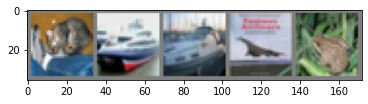

Correct Classification:  cat   ship  ship  plane frog 


In [135]:
# load an interation of data for testing
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
show_image(torchvision.utils.make_grid(images))

# show the classifications and images for the images
# not showing the testing yet
print("Correct Classification: ", ' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

Now we can go back to the saved model and test again this.

Model was saved previously for future use.

In [136]:
# load network
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

This output confirms to us that we have used the correct path and correct information.

Now we can see the output from the neural network.

In [137]:
outputs = net(images)

Outputs are the energies for the 10 classes. The higher the energy, the more the network associates the image with a particular class. 

A metric we want to know now is the image with the highest energy.

In [138]:
_, predicted = torch.max(outputs, 1)


# view the predictions
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(5)))

Predicted:  plane plane plane plane plane


Now we can see how the network performed when going through the whole network. 
Additionally, we can get an accuracy over all of the images. 


Moreover, we are going to see which classes performed the best. Assuming that we get a good accuracy, we can see what the network was best at identifying.

In [154]:

num_epochs = 10

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
start_time = time.time()
    
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

running_loss = []
running_test_acc = []
t = trange(num_epochs, desc="Training loss", leave=True)

for epoch in t:
        #loss_epoch = train(net, trainloader, optimizer,criterion)
        test_acc = test(net, testloader)
        t.set_description("Training loss = %f test accuracy = %f" % (np.mean(loss_epoch), test_acc))
        t.refresh() # to show immediately the update           
        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)

# Get final time to test
print("\n--- %s seconds ---" % (time.time() - start_time))



























Training loss:   0%|          | 0/10 [00:00<?, ?it/s]

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

This is much better than the random chance which would be about 10% when choosing between 10 images. 